

We will be predicting whether a cyclone status is a tropical depression (TD) or not(i.e. we will solve classification task).  
Status can be the following types:  
* TD – tropical depression  
* TS – tropical storm   
* HU – hurricane intensity  
* EX – Extratropical cyclone  
* SD – subtropical depression intensity  
* SS – subtropical storm intensity  
* LO – low, neither a tropical, subtropical, nor extratropical cyclone  
* WV – Tropical Wave  
* DB – Disturbance  


In [2]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools, time
import matplotlib.pyplot as plt
import matplotlib.patheffects as peffects
import time as timelib

from math import ceil, floor
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import explained_variance_score, confusion_matrix
from sklearn.metrics import f1_score, mean_squared_error, roc_curve, auc
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 12

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%matplotlib inline
plt.style.use('ggplot')

# LOADING THE DATA

In [3]:
filename = 'atlantic.csv'
cyclones_full = pd.read_csv(filename)
nRows, nCols = cyclones_full.shape
print(f'{nRows} rows and {nCols} columns')

49105 rows and 22 columns


In [4]:
targetnames = ['notTropDepress', 'isTropDrepress']
# Determine the positve count
isTD = cyclones_full['Status'].str.contains('TD')
cyclones_full['isTD'] = isTD
npos = isTD.sum() 
nneg = nRows - npos 

# Compute the postive fraction
pos_fraction = npos / nRows
neg_fraction = 1 - pos_fraction
pos_fraction, neg_fraction

(npos, pos_fraction), (nneg, neg_fraction)

((9891, 0.20142551674982181), (39214, 0.7985744832501782))

Make some adjustments to the data.

For wind speed, NaNs are current represented by -999.
We will replace these with NaN.

For Latitude and Longitude, these are strings such as 
28.0W. We will replace these with numerical values where
positive directions are N and E, and negative directions 
are S and W.

In [6]:
# Convert -999 values to NaNs. These are missing values
NaNvalue = -999
cyclones_nans = cyclones_full.replace(NaNvalue, np.nan).copy()

# Set the datatype of the categorical attributes
cate_attribs = ['Event', 'Status']
cyclones_nans[cate_attribs] = cyclones_full[cate_attribs].astype('category')

# Set the datatype of the Data attribute to datetime64[ns]
cyclones_nans['Date'] = cyclones_nans['Date'].astype('datetime64[ns]')

# Convert Latitude and Longitude into numerical values
def to_numerical(coord):
    direction = re.findall(r'[NSWE]' , coord)[0]
    num = re.match('[\d]{1,3}.[\d]{0,1}' , coord)[0]
    
    # North and East are positive directions
    if direction in ['N', 'E']:
        return float(num)
    return -1. * float(num)

cyclones_nans['Latitude'] = cyclones_nans['Latitude'].apply(to_numerical)
cyclones_nans['Longitude'] = cyclones_nans['Longitude'].apply(to_numerical)
cyclones_nans[['Latitude', 'Longitude']].head(3)

,Latitude,Longitude
0,28.0,-94.8
1,28.0,-95.4
2,28.0,-96.0


Display the quantitiy of NaNs for each feature

In [7]:
cyclones_nans.isna().sum()

ID                      0
Name                    0
Date                    0
Time                    0
Event                   0
Status                  0
Latitude                0
Longitude               0
Maximum Wind            0
Minimum Pressure    30669
Low Wind NE         43184
Low Wind SE         43184
Low Wind SW         43184
Low Wind NW         43184
Moderate Wind NE    43184
Moderate Wind SE    43184
Moderate Wind SW    43184
Moderate Wind NW    43184
High Wind NE        43184
High Wind SE        43184
High Wind SW        43184
High Wind NW        43184
isTD                    0
dtype: int64

Display summary statistics for each feature of the dataframe

In [8]:
cyclones_nans.describe()

,Time,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49105.000000,49105.000000,49105.000000,18436.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000
mean,910.125975,27.044904,-65.682533,52.005091,992.244250,81.865394,76.518325,48.647188,59.156393,24.641952,23.029894,15.427293,18.403141,8.110117,7.357710,5.130890,6.269211
std,671.043363,10.077880,19.687240,27.681902,19.113748,88.097930,87.563153,75.209183,77.568911,41.592337,42.017821,32.105372,35.411258,19.792002,18.730334,14.033464,16.876623
min,0.000000,7.200000,-359.100000,-99.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,600.000000,19.100000,-81.000000,35.000000,984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1200.000000,26.400000,-68.000000,45.000000,999.000000,60.000000,60.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1800.000000,33.100000,-52.500000,70.000000,1006.000000,130.000000,120.000000,75.000000,90.000000,40.000000,35.000000,20.000000,30.000000,0.000000,0.000000,0.000000,0.000000
max,2330.000000,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


# PRE-PROCESS AND CLEAN THE DATA

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder

# Pipeline component: select subsets of attributes
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        return X[self.attribs]
# Pipeline component: drop all rows that contain invalid values
class DataSampleDropper(BaseEstimator, TransformerMixin):
    def __init__(self, how='any'):
        self.how = how
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        return X.dropna(how=self.how)

In [10]:
cyclones_nans.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW', 'isTD'],
      dtype='object')

Construct preprocessing pipeline

In [11]:
dropped_features = ['ID', 'Name', 'Date', 'Time', 'Status', 'Event']

selected_features = ['Latitude', 'Longitude', 'Low Wind SW', 'Moderate Wind NE', 
                     'Moderate Wind SE', 'High Wind NW', 'isTD']

pipe = Pipeline([
    ('FeatureSelector', DataFrameSelector(selected_features)),
    ('RowDropper', DataSampleDropper())
])

Pre-process the data using the defined pipeline

In [12]:
processed_data = pipe.fit_transform(cyclones_nans)
nsamples, ncols = processed_data.shape
nsamples, ncols

(5921, 7)

Verify all NaNs removed

In [13]:
processed_data.isna().any()

Latitude            False
Longitude           False
Low Wind SW         False
Moderate Wind NE    False
Moderate Wind SE    False
High Wind NW        False
isTD                False
dtype: bool

# VISUALIZE DATA

Display the distributions of the data
use visualize.featureplots
to generate trace plots, histograms, boxplots, and probability plots for
each feature.

A probability plot is utilized to evaulate the normality of a distribution.
The data are plot against a theoritical distribution, such that if the data 
are normal, they'll follow the diagonal line. See the reference above for 
more information

In [14]:
from copy import deepcopy
from scipy import stats

def myplots(x, name):
    xplt = deepcopy(x)
    med = np.nanmedian(xplt)
    mu = np.nanmean(xplt)
    sig = np.nanstd(xplt)
    mn = np.nanmin(xplt)
    mx = np.nanmax(xplt)
    fig = plt.figure(figsize=(14,3))
    # Sequence plot
    plt.subplot(1,4,1)
    plt.plot(xplt)
    plt.hlines(mu, 0, xplt.shape[0], colors='r', linestyles='dashed', label='mean')
    plt.ylabel(name)
    # Histogram
    plt.subplot(1,4,2)
    (n, b, p) = plt.hist(xplt)
    plt.plot((mu, mu), (0, np.max(n)), 'r--')
    plt.xlabel(name) 
    # Boxplot
    plt.subplot(1,4,3)
    plt.boxplot(xplt, labels=[name])
    plt.ylabel(name)
    plt.tight_layout()
    # Probability Plot
    subplt = plt.subplot(1,4,4)
    (osm, osr), (slope, intercept, r) = stats.probplot(xplt, dist='norm', plot=subplt)
    plt.tight_layout()
    plt.show()

In [15]:
def featureplots(X, feature_names):
    for f, feature_name in enumerate(feature_names):
        print("FEATURE:", feature_name)
        x = X[:, f]
        myplots(x, feature_name)

FEATURE: Latitude


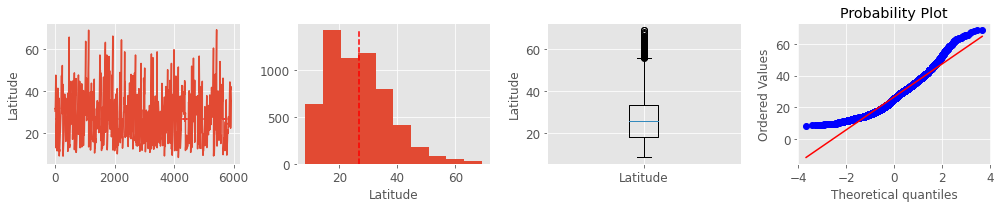

FEATURE: Longitude


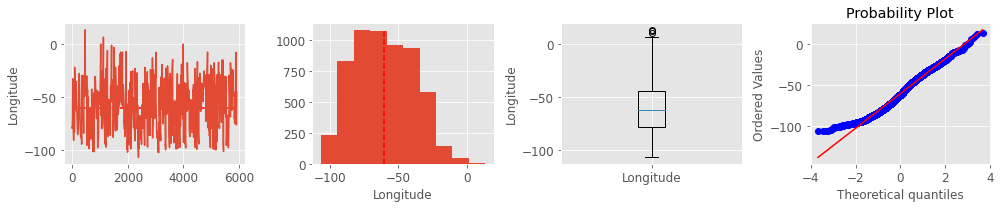

FEATURE: Low Wind SW


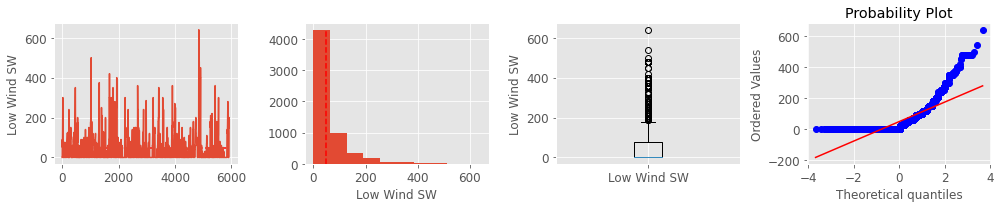

FEATURE: Moderate Wind NE


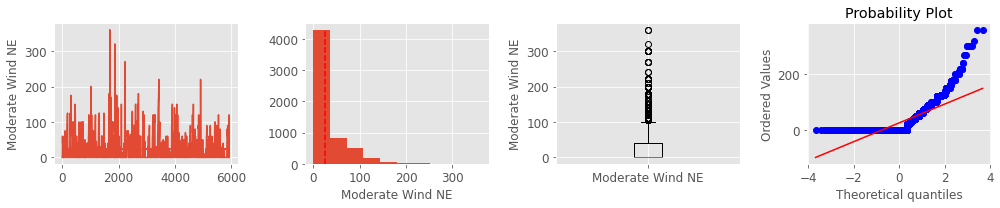

FEATURE: Moderate Wind SE


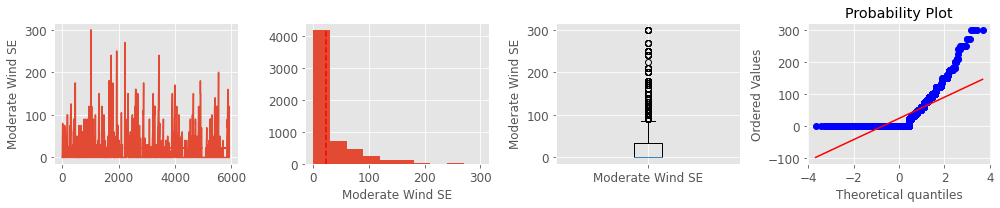

FEATURE: High Wind NW


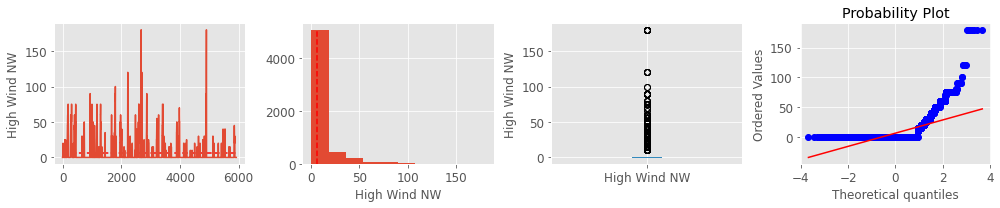

FEATURE: isTD


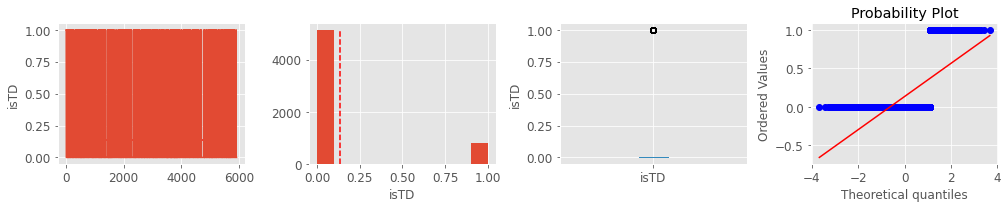

In [16]:
cdata = processed_data.astype('float64').copy()
featureplots(cdata.values, cdata.columns)

Display the Pearson correlation between all pairs of the features
use visualize.scatter_corrplots

In [17]:
def scatter_corrplots(X, feature_names, corrfmt="%.3f", FIGW=15):
    ncorrs = len(feature_names)
    corrs = np.corrcoef(X.T)
    thresh = .6
    fig, axs = plt.subplots(nrows=ncorrs, ncols=ncorrs, figsize=(FIGW, FIGW))
    for f1, f1_name in enumerate(feature_names):
        for f2, f2_name in enumerate(feature_names):
            # Correlation colorimage
            if f1 < f2:
                cr = corrs[f1, f2]
                im = axs[f1, f2].imshow(np.array([[cr, cr], [cr, cr]]), 
                                        cmap='RdBu', vmin=-1, vmax=1)
                text = axs[f1, f2].text(.5, .5, corrfmt % cr, ha="center", va="center", 
                                        color="w" if abs(cr) > thresh else "k",
                                        fontdict=dict(fontsize=8))
            if f1 == 0 and f2 == (ncorrs - 1):
                cbar = axs[f1, f2].figure.colorbar(im, ax=axs[f1, f2])
                cbar.ax.set_ylabel("Pearson Correlation", rotation=-90, va="bottom")
            # Feature histogram
            if f1 == f2:
                axs[f1, f2].hist(X[:, f1], color='green')
            # Feature scatter plot
            if f1 > f2:
                axs[f1, f2].scatter(X[:, f2], X[:, f1], s=1, alpha=.7)

            if ncorrs > 10 or f1 < (ncorrs - 1): axs[f1, f2].set_xticks([])
            if ncorrs > 10 or f2 > 0: axs[f1, f2].set_yticks([])

            if f1 == (ncorrs - 1): axs[f1, f2].set_xlabel(f2_name, rotation=90)
            if f2 == 0: axs[f1, f2].set_ylabel(f1_name, rotation=0)

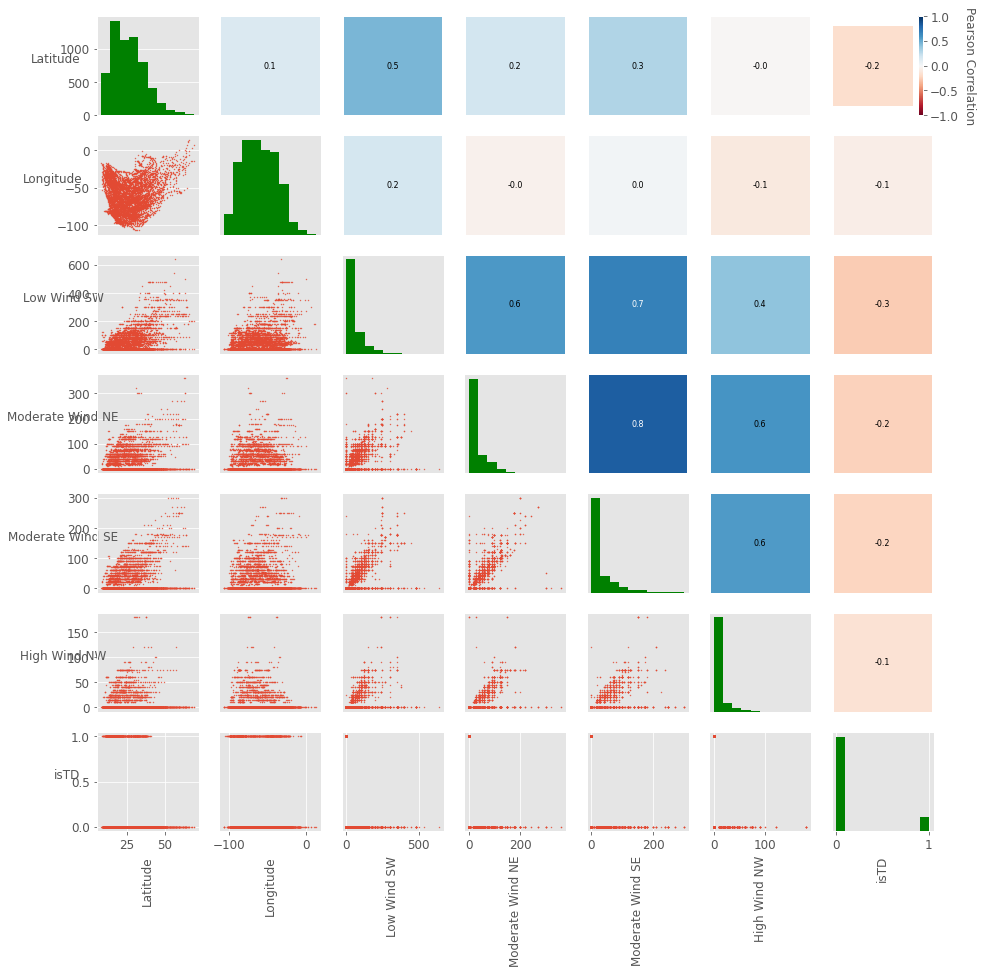

In [18]:
scatter_corrplots(cdata.values, cdata.columns, corrfmt="%.1f", FIGW=15)

Extract the positive and negative cases

In [19]:
# Get the positions of the positive and negative labeled examples
pos_inds = processed_data['isTD'] == 1
neg_inds = processed_data['isTD'] == 0

# Get the actual corresponding examples
pos = processed_data[pos_inds]
neg = processed_data[neg_inds]

# Positive Fraction
npos = pos_inds.sum()
nneg = nsamples - npos
pos_frac = npos / nsamples
neg_frac = 1 - pos_frac
(npos, pos_frac), (nneg, neg_frac)

((788, 0.13308562742779936), (5133, 0.8669143725722006))

# CLASSIFICATION

Split the data

In [21]:

#Separate X and y. We are predicting isTD
X = processed_data.drop(columns = ['isTD'])
y = processed_data['isTD']

#Hold out 20% of the data for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DECISION TREE CLASSIFIER

Create and train DecisionTree for comparision with the ensemble methods

In [22]:
tree_clf = DecisionTreeClassifier(max_depth=200, max_leaf_nodes=10)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=200, max_leaf_nodes=10)

Compute the predictions, prediction probabilities, and the accuracy scores
for the trianing and validation sets

In [23]:
def confusion_mtx_colormap(mtx, xnames, ynames, cbarlabel=""):
    nxvars = mtx.shape[1]
    nyvars = mtx.shape[0]
    # create the figure and plot the correlation matrix
    fig, ax = plt.subplots()
    im = ax.imshow(mtx, cmap='summer', zorder=1)
    if not cbarlabel == "":
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    # Specify the row and column ticks and labels for the figure
    ax.set_xticks(range(nxvars))
    ax.set_yticks(range(nyvars))
    ax.set_xticklabels(xnames)
    ax.set_yticklabels(ynames)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("Actual Labels")
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, 
             ha="right", rotation_mode="anchor")
    lbl = np.array([['TN', 'FP'], ['FN', 'TP']])
    for i in range(nyvars):
        for j in range(nxvars):
            thresh = mtx.sum() / 2
            text = ax.text(j, i, "%s = %.3f" % (lbl[i,j], mtx[i, j]),
                           ha='center', va='center', color='k' if mtx[i, j] > thresh else 'w')
    return fig, ax

In [24]:
import matplotlib.patheffects as peffects

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import explained_variance_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def ks_roc_prc_plot(targets, scores, FIGWIDTH=15, FIGHEIGHT=6, FONTSIZE=14):
    # Compute ROC
    fpr, tpr, thresholds = roc_curve(targets, scores)
    auc_roc = auc(fpr, tpr)
    precision, recall, thresholds_prc = precision_recall_curve(targets, scores)
    auc_prc = auc(recall, precision)

    roc_results = {'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds, 'auc':auc_roc}
    prc_results = {'precision':precision, 'recall':recall,
                   'thresholds':thresholds_prc, 'auc':auc_prc}
    pos = np.where(targets)[0]
    npos = targets.sum()
    pos_frac = npos / targets.size
    fig, ax = plt.subplots(1, 3, figsize=(FIGWIDTH,FIGHEIGHT))
    axs = ax.ravel()
    
    ax[0].plot(thresholds, tpr, color='b')
    ax[0].plot(thresholds, fpr, color='r')
    ax[0].plot(thresholds, tpr - fpr, color='g')
    ax[0].invert_xaxis()
    ax[0].set(xlabel='threshold', ylabel='fraction')
    ax[0].legend(['TPR', 'FPR', 'K-S Distance'], fontsize=FONTSIZE)
    ax[1].plot(fpr, tpr, color='b')
    ax[1].plot([0,1], [0,1], 'r--')
    ax[1].set(xlabel='FPR', ylabel='TPR')
    ax[1].set_aspect('equal', 'box')
    auc_text = ax[1].text(.05, .95, "AUC = %.4f" % auc_roc, 
                          color="k", fontsize=FONTSIZE)
    ax[2].plot(recall, precision, color='b')
    ax[2].plot([0, 0, 1], [1, pos_frac, pos_frac], 'r--')
    ax[2].set(xlabel='Recall', ylabel='Precision')
    ax[2].set_aspect('equal', 'box')
    auc_prc_text = plt.text(.2, .95, "PR AUC = %.4f" % auc_prc, 
                            color="k", fontsize=FONTSIZE)
    pos_frac_text = plt.text(.2, .85, "%.2f %% pos" % (pos_frac * 100), 
                             color="k", fontsize=FONTSIZE)

    return roc_results, prc_results, fig, axs

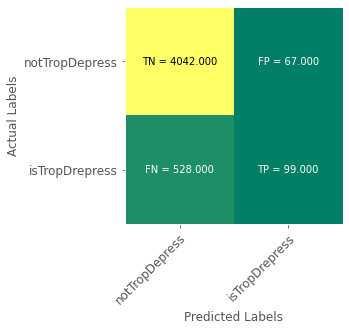

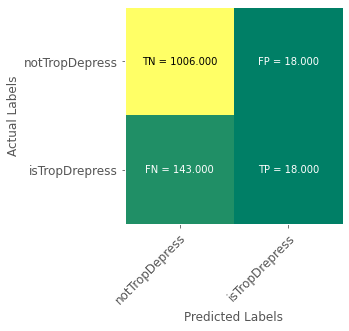

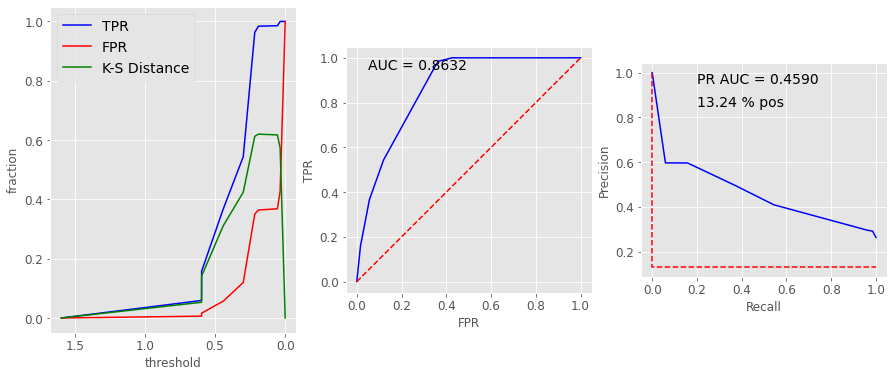

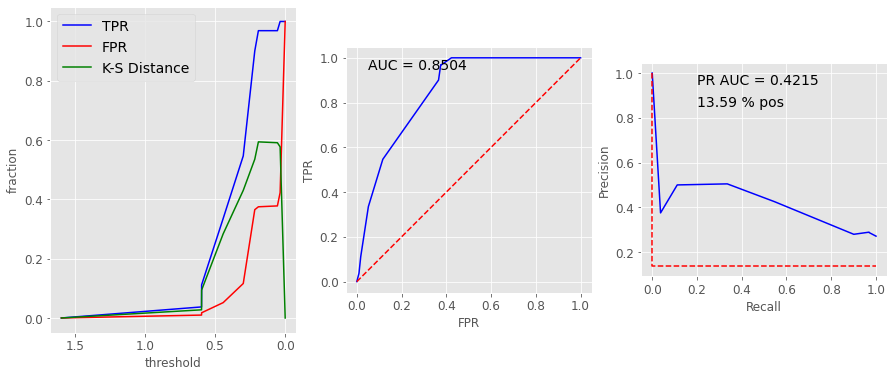

In [25]:
# Compute the model's predictions
dt_preds = tree_clf.predict(X_train)
dt_preds_val = tree_clf.predict(X_test)

# Compute the prediction probabilities
dt_proba = tree_clf.predict_proba(X_train)
dt_proba_val = tree_clf.predict_proba(X_test)

# Compute the model's mean accuracy
dt_score = tree_clf.score(X_train, y_train) 
dt_score_val = tree_clf.score(X_test, y_test)

# Confusion Matrix
dt_cmtx = confusion_matrix(y_train, dt_preds)
dt_cmtx_val = confusion_matrix(y_test, dt_preds_val)
confusion_mtx_colormap(dt_cmtx, targetnames, targetnames)
confusion_mtx_colormap(dt_cmtx_val, targetnames, targetnames)

# KS, ROC, and PRC Curves
dt_roc_prc_results = ks_roc_prc_plot(y_train, dt_proba[:,1])
dt_roc_prc_results_val = ks_roc_prc_plot(y_test, dt_proba_val[:,1])

# FEATURE IMPORTANCE

Display the feature imporantances

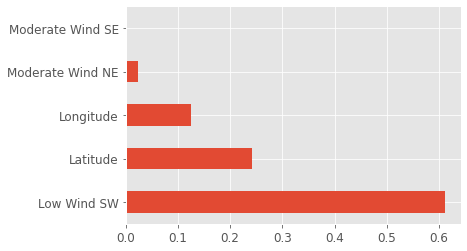

In [28]:
feat_importances = pd.Series(tree_clf.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

# CONCLUSIONS:

First, from the feature importances map we can see that the most important feature is Low Wind SW.

Second, about the model - we can say that DECISION TREE CLASSIFIER performs well on our data, thus:



1.   AUC score is 0.85, which is very good result. The closer the AUC score to 1 the better the model is able to classify observations into classes.
2.   Accuracy of our model is 0.86. Which means that our model 86% accurate in predictions.


